In [1]:
!which python

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/bin/python


In [2]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [3]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [4]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [11]:
analysis_dir = '/data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/'

In [12]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/denovo/SNPcall/test/filtering


In [13]:
vcf_file = os.path.join(analysis_dir, "fb_cat.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/fb_cat.vcf.gz'

# Filter first round 
    missing data, MAF, biallelic

In [8]:
!$vcftools --remove-indels \
--max-missing 0.6 \
--min-alleles 2 \
--max-alleles 2 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'fb_miss60_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/fb_cat.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--max-alleles 2
	--min-alleles 2
	--thin 100
	--max-missing 0.6
	--out fb_miss60_thin100_MAF2
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting VCF file...
After filtering, kept 55771 out of a possible 503227 Sites
Run Time = 9.00 seconds


In [14]:
vcf_filtered = "%s.recode.vcf" % (analysis_dir + 'fb_miss60_thin100_MAF2')
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [15]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv


In [16]:
!$vcftools --gzvcf $vcf_filtered_gz --out $vcf_filtered_gz --missing-indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/fb_miss60_thin100_MAF2.recode.vcf.gz
	--missing-indv
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/fb_miss60_thin100_MAF2.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Individual Missingness
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds


In [17]:
def get_imiss(vcf_file):
    imiss_file = !ls {vcf_file}.imiss
    imiss_df = pd.read_csv(imiss_file[0], sep="\t")
    imiss_df.index = imiss_df.INDV
    return imiss_df

In [18]:
imiss_df = get_imiss(vcf_filtered_gz)
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
AT2_EW_36,AT2_EW_36,55771,0,5348,0.095892
AT2_HC_2,AT2_HC_2,55771,0,6655,0.119327
AT2_VM_5,AT2_VM_5,55771,0,10004,0.179376
AT2_YB_79,AT2_YB_79,55771,0,5674,0.101737
AT4_DS_2,AT4_DS_2,55771,0,6639,0.119040


In [19]:
imiss_df.F_MISS.describe()

count    15.000000
mean      0.111447
std       0.041134
min       0.042818
25%       0.086586
50%       0.114432
75%       0.130722
max       0.190637
Name: F_MISS, dtype: float64

In [20]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .4]),len(imiss_df[imiss_df.F_MISS >= .5]), len(imiss_df[imiss_df.F_MISS >= .25])


(15, 0, 0, 0)

In [21]:
bad_indv = imiss_df.INDV[imiss_df.F_MISS >= .4]

In [22]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv.index:
        o.write("%s\n" % elem)

In [23]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/fb_miss60_thin100_MAF2.recode.vcf.gz
	--remove /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 15 out of 15 Individuals
Outputting VCF file...
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 5.00 seconds


In [24]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [25]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [26]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Mean Depth by Individual
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11


After filtering, kept 15 out of 15 Individuals
Outputting Depth for Each Site
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--site-mean-depth

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Depth for Each Site
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--site-quality

Using zlib version

After filtering, kept 15 out of 15 Individuals
Outputting Quality for Each Site
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--missing-site

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Site Missingness
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--freq
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11


After filtering, kept 15 out of 15 Individuals
Outputting Frequency Statistics...
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--counts
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Frequency Statistics...
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11

After filtering, kept 15 out of 15 Individuals
Outputting HWE statistics (but only for biallelic loci)
	HWE: Only using fully diploid SNPs.
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Individual Heterozygosity
	Individual Heterozygosity: Only using fully diploid SNPs.
After filtering, kept 55771 out of a possible 55771 Sites
Run Time = 1.00 seconds


In [27]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [28]:
vcf_bad_remove_gz

'/data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz'

In [29]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [30]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
dDocent_Contig_10000-23,979,82465,65.26670,1326.35000,30,0,0,0.000000,11.73230,2,...,0.017836,1.000000,1.0,1.000000,T,G,0.966667,0.033333,0.033333,0.000000
dDocent_Contig_100004-25,1204,104028,80.26670,527.63800,30,0,0,0.000000,5829.85000,2,...,15.000000,0.000211,1.0,0.000211,C,T,0.500000,0.500000,0.500000,-0.933333
dDocent_Contig_100010-6,75,851,6.25000,34.75000,27,0,3,0.111111,76.26020,2,...,NaN,NaN,NaN,NaN,C,T,0.958333,0.041667,0.041667,-9.000000
dDocent_Contig_100024-5,467,23241,31.13330,621.55200,30,0,0,0.000000,136.38400,2,...,0.600000,1.000000,1.0,0.674330,G,A,0.833333,0.166667,0.166667,-0.160000
dDocent_Contig_100034-5,77,561,5.13333,11.83810,30,0,0,0.000000,61.65040,2,...,0.076531,1.000000,1.0,0.965517,C,T,0.933333,0.066667,0.066667,-0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dDocent_Contig_99965-22,164,2578,12.61540,42.42310,28,0,2,0.071429,100.04900,2,...,NaN,NaN,NaN,NaN,C,A,0.961538,0.038462,0.038462,-9.000000
dDocent_Contig_99971-4,109,1011,7.78571,12.48900,29,0,1,0.034483,698.96300,2,...,NaN,NaN,NaN,NaN,G,T,0.642857,0.357143,0.357143,-9.000000
dDocent_Contig_99987-7,74,732,7.40000,20.48890,25,0,5,0.200000,15.24600,2,...,NaN,NaN,NaN,NaN,G,T,0.950000,0.050000,0.050000,-9.000000
dDocent_Contig_99992-28,240,5430,17.14290,101.20900,29,0,1,0.034483,91.64640,2,...,NaN,NaN,NaN,NaN,C,A,0.928571,0.071429,0.071429,-9.000000


In [31]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
dDocent_Contig_469-22,dDocent_Contig_469,22,2,30,T:0.9,C:0.1
dDocent_Contig_2655-87,dDocent_Contig_2655,87,2,24,A:0.916667,C:0.0833333
dDocent_Contig_2973-21,dDocent_Contig_2973,21,2,30,C:0.5,T:0.5
dDocent_Contig_3819-42,dDocent_Contig_3819,42,2,30,T:0.5,A:0.5
dDocent_Contig_3966-63,dDocent_Contig_3966,63,2,30,T:0.866667,A:0.133333
...,...,...,...,...,...,...
dDocent_Contig_448372-7,dDocent_Contig_448372,7,2,28,A:0.964286,G:0.0357143
dDocent_Contig_450674-2,dDocent_Contig_450674,2,2,28,C:0.714286,T:0.285714
dDocent_Contig_458652-4,dDocent_Contig_458652,4,2,24,G:0.958333,A:0.0416667
dDocent_Contig_460788-32,dDocent_Contig_460788,32,2,22,A:0.954545,G:0.0454545


In [32]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
dDocent_Contig_469-22,dDocent_Contig_469,22,12/3/0,12.15/2.70/0.15,0.185185,1.000000,1.00000,0.896552
dDocent_Contig_2973-21,dDocent_Contig_2973,21,0/15/0,3.75/7.50/3.75,15.000000,0.000211,1.00000,0.000211
dDocent_Contig_3819-42,dDocent_Contig_3819,42,0/15/0,3.75/7.50/3.75,15.000000,0.000211,1.00000,0.000211
dDocent_Contig_3966-63,dDocent_Contig_3966,63,11/4/0,11.27/3.47/0.27,0.355030,1.000000,1.00000,0.796935
dDocent_Contig_4271-10,dDocent_Contig_4271,10,0/15/0,3.75/7.50/3.75,15.000000,0.000211,1.00000,0.000211
...,...,...,...,...,...,...,...,...
dDocent_Contig_336302-5,dDocent_Contig_336302,5,0/14/1,3.27/7.47/4.27,11.484380,0.001734,1.00000,0.001690
dDocent_Contig_351207-21,dDocent_Contig_351207,21,11/3/1,10.42/4.17/0.42,1.176000,0.325670,0.32567,0.980843
dDocent_Contig_383096-28,dDocent_Contig_383096,28,14/1/0,14.02/0.97/0.02,0.017836,1.000000,1.00000,1.000000
dDocent_Contig_409231-6,dDocent_Contig_409231,6,12/3/0,12.15/2.70/0.15,0.185185,1.000000,1.00000,0.896552


In [33]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [34]:
loci_df.SUM_DEPTH.describe()

count    5.577100e+04
mean     5.103283e+02
std      1.088253e+04
min      9.000000e+00
25%      5.300000e+01
50%      9.300000e+01
75%      2.150000e+02
max      2.485918e+06
Name: SUM_DEPTH, dtype: float64

In [35]:
loci_df.QUAL.describe()

count    5.577100e+04
mean     1.950249e+03
std      5.863799e+04
min      7.959420e-08
25%      3.006505e+01
50%      8.368840e+01
75%      2.819060e+02
max      1.289440e+07
Name: QUAL, dtype: float64

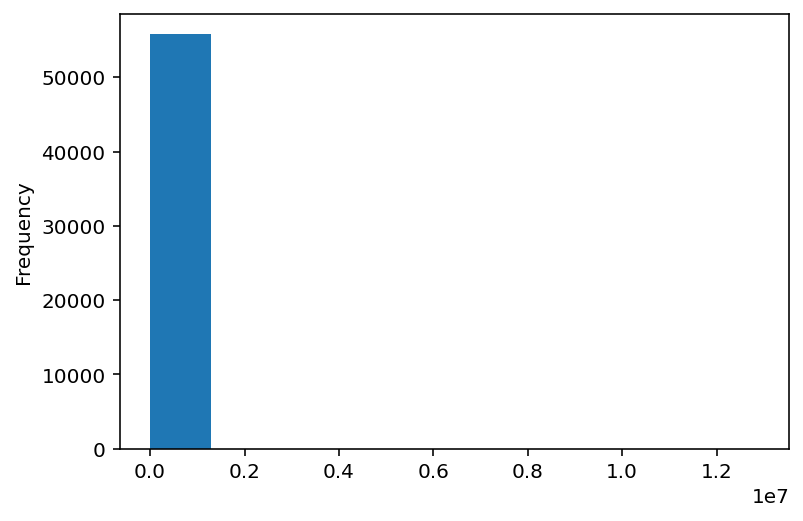

In [36]:
loci_df.QUAL.plot(kind="hist");

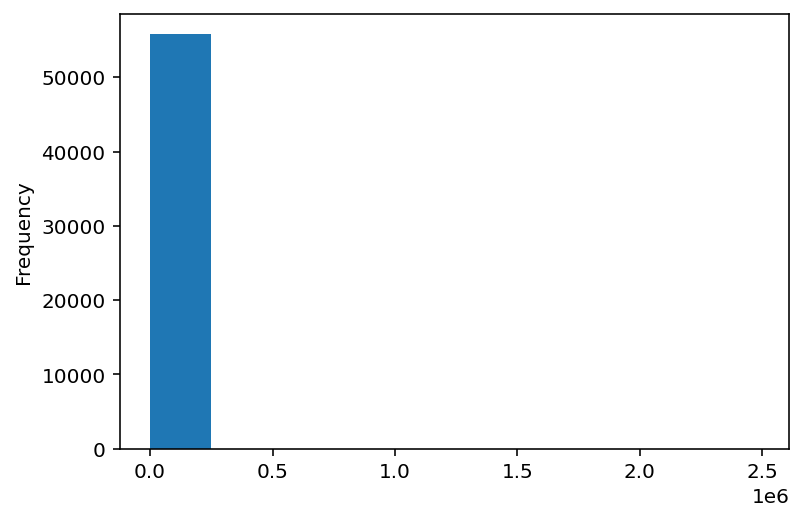

In [37]:
loci_df.SUM_DEPTH.plot(kind="hist");

In [38]:
len(loci_df[loci_df.Fis == -9])

31315

In [48]:
len(loci_df[loci_df.SUM_DEPTH <1000]),len(loci_df[loci_df.SUM_DEPTH >=75])

(51933, 33019)

In [40]:
len(loci_df[loci_df.QUAL >= 10]) - len(loci_df[loci_df.QUAL >= 20])

3947

In [44]:
len(loci_df[loci_df.QUAL <  100]), len(loci_df[loci_df.QUAL < 50]), len(loci_df[loci_df.QUAL < 30])

(30502, 20105, 13880)

In [42]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(35404, 0)

#### DO NOT remove based off Fis

In [49]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.SUM_DEPTH >= 75) & 
                  (df.SUM_DEPTH < 1000) & 
                  (df.QUAL >= 30) & 
                  (df.MAF >= 0.02)]

In [50]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(22254, 25)

In [51]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [52]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps
	--positions /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting VCF file...
After filtering, kept 22254 out of a possible 55771 Sites
Run Time = 2.00 seconds


In [53]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Plink / chrom_map

In [54]:
chroms = sorted(set([x.split("-")[0] for x in loci_df.index]))
len(chroms) # number of unique contigs

55771

In [55]:
with open(os.path.join(analysis_dir, "chrom_map.txt"), "w") as o:
    for i, c in enumerate(chroms):
        o.write("%s\t%d\n" % (c, i))

In [56]:
def write_plink_files(vcf_gz):
    !$vcftools --gzvcf {vcf_gz} \
    --out {vcf_gz} \
    --plink \
    --chrom-map {os.path.join(analysis_dir, "chrom_map.txt")}

In [57]:
write_plink_files(snps_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf.gz
	--chrom-map /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/chrom_map.txt
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf.gz
	--plink

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Writing PLINK PED and MAP files ... 
	Read 55772 chromosome mapping file entries.
Done.
After filtering, kept 22254 out of a possible 22254 Sites
Run Time = 1.00 seconds


# Make 012

In [58]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf
	--012
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 22254 out of a possible 22254 Sites
Run Time = 0.00 seconds


# Get coverage per individual

In [59]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf
	--depth
	--out /data/gpfs/home/tfaske/d/sagebrush/denovo/SNPcall/test/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 15 out of 15 Individuals
Outputting Mean Depth by Individual
After filtering, kept 22254 out of a possible 22254 Sites
Run Time = 0.00 seconds


In [60]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_EW_36,21614,16.12890
1,AT2_HC_2,21403,14.45060
2,AT2_VM_5,20519,9.86954
3,AT2_YB_79,21514,18.01830
4,AT4_DS_2,20524,23.54840


In [61]:
depth_df.MEAN_DEPTH.describe()

count    15.000000
mean     16.875816
std       3.777805
min       9.869540
25%      14.480400
50%      17.110200
75%      18.205050
max      24.618500
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [62]:
!rm snps*

In [63]:
!rm fb*

In [64]:
!rm *vcf